<a href="https://colab.research.google.com/github/Camilojaravila/202220_MINE-4210_ANALISIS_CON_DEEP_LEARNING/blob/main/Laboratorio%204/Sesi%C3%B3n%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)







# **Laboratorio 4. 4**

## **Objetivos**
*   Entender la generación de Imágenes Aleatorias.
*   Analizar la Arquitectura de los AutoEncoders Variacionales.
*   Generar imágenes a partir de un VAE.


## **Problema**
- Para este problema, vamos a utilizar un conjunto de imágenes llamado [Fashion MNIST](https://www.tensorflow.org/datasets/catalog/fashion_mnist), el cual consta de 10 productos catalogados por imagenes, cada imagen viene de tamaño 28 x 28 y en escala de grises.

### 0. Importación de paquetes

Para este ejercicio, utilizaremos las siguientes librerías.

In [ ]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from keras.models import Model
from keras.losses import binary_crossentropy
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras import backend as K
from keras import applications
from keras.utils.vis_utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.9.2


In [ ]:
import tensorflow as tf; tf.compat.v1.disable_eager_execution()

### 1. Entendimiento del Negocio

El negocio nos ha bridado el siguiente diccionario de datos:

Este Dataset consta de 60,000 28x28 imágenes a escala de grises de 10 categorias de ropa, junto a un conjunto de 10,000 imágenes de test.

Las clases son:

|Etiqueta|Descripción|
|---|---|
|0|T-shirt/top|
|1|Trouser|
|2|Pullover|
|3|Dress|
|4|Coat|
|5|Sandal|
|6|Shirt|
|7|Sneaker|
|8|Bag|
|9|Ankle boot|

### 2. Entendimeinto de los Datos

Realizamos la carga del código, para validar si la carga de los datos es correcta.

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

Visualizamos al azar una imagen, para poder verificar que se haya realizado la carga.

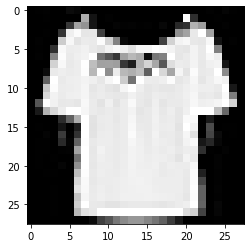

In [ ]:
# select any random index from 1 to 60,000
i = random.randint(1,X_train.shape[0])
plt.imshow(X_train[i] , cmap = 'gray')

In [ ]:
label = y_train[i]
label

6

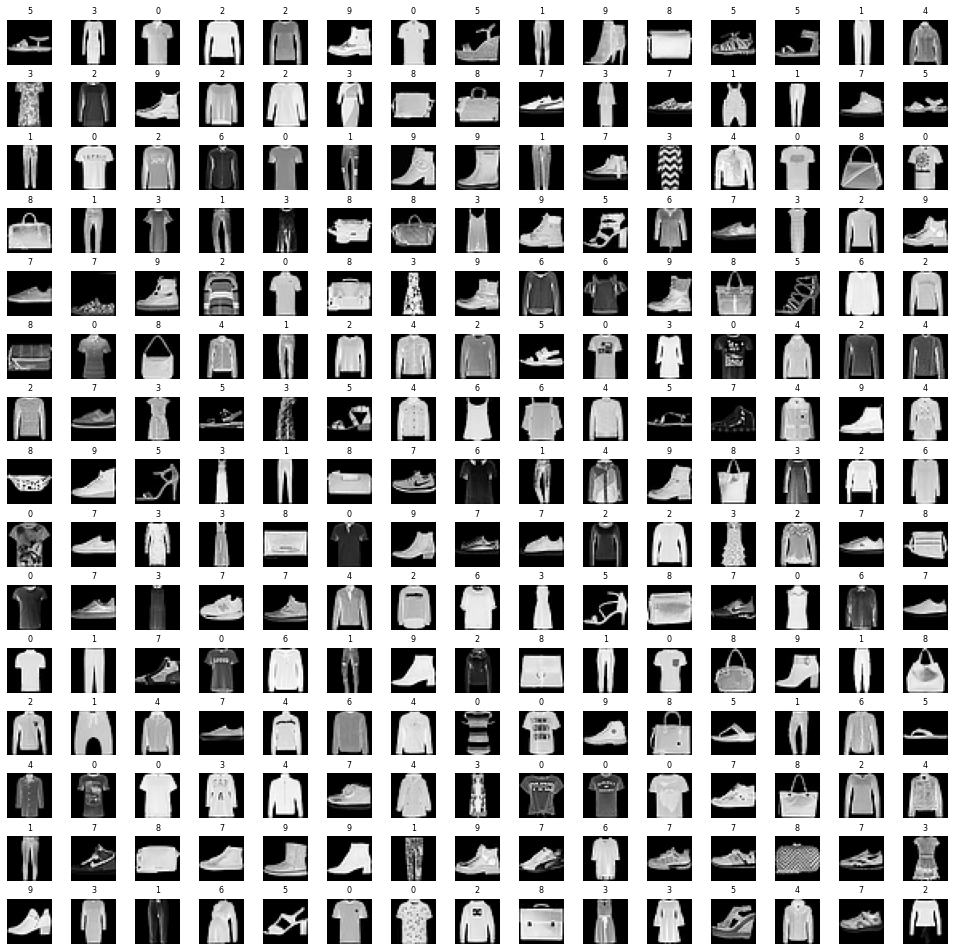

In [ ]:
W_grid = 15
L_grid = 15

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array
n_training = len(X_train) # get the length of the training dataset

# Select a random number from 0 to n_training
for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, n_training)
    axes[i].imshow( X_train[index], cmap='gray')
    axes[i].set_title(y_train[index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

## 2. Preparación de datos

Para entrenar el modelo, realizamos una normalización de los datos para que se encuentren entre el rango [0,1]. Esto no afectará la construcción de la imagen.

In [ ]:
X_train = X_train / 255
X_test = X_test / 255

X_train_new = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test_new = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

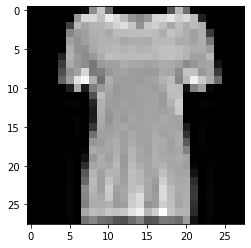

In [ ]:
plt.imshow(X_train[10].reshape(28, 28), cmap="gray")

Luego definiremos algunos parámetros para su posterior reconstrucción. definiremos de qué tamaño será nuestro espacio latente.

In [ ]:
img_height   = X_train_new.shape[1]    # 28
img_width    = X_train_new.shape[2]    # 28
num_channels = X_train_new.shape[3]    # 1
input_shape =  (img_height, img_width, num_channels)   # (28,28,1)
latent_dim = 2    # Dimension of the latent space

Con nuestra arquitectura en mente, procedemos a construir nuestro encoder por capas. Como se darán cuenta, esta forma de construir y conectar capas es un poco diferente a la que veníamos manejando tradicionalmente. Ya veremos el resultado de realizarlo de esta forma.

In [ ]:
encoder_input = Input(shape=input_shape)

encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=16, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder = Flatten()(encoder_conv)

mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)

Definimos una función que nos ayuda a calcular el espacio latente de la imagen codificada.

In [ ]:
def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

In [ ]:
latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])

In [ ]:
conv_shape = K.int_shape(encoder_conv)
conv_shape

(None, 14, 14, 16)

Luego, como parte de Autoencoder definimos su decoder. Es importante tener en cuenta que al utilizar capas convolucionales en la codificación, podemos usar las capas transpuestas para su decodificación. 

In [ ]:
decoder_input = Input(shape=(latent_dim,))
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)
decoder_conv = Conv2DTranspose(filters=16, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv =  Conv2DTranspose(filters=num_channels, kernel_size=3, 
                          padding='same', activation='sigmoid')(decoder_conv)

Definimos como modelos nuestro Encoder y Decoder.

In [ ]:
encoder = Model(encoder_input, latent_space, name='VAE_Encoder')
decoder = Model(decoder_input, decoder_conv, name='VAE_Decoder')

In [ ]:
encoder.summary()

Model: "VAE_Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 16)   160         ['input_1[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                                  
 dense (Dense)                  (None, 2)            6274        ['flatten[0][0]']                
                                                                                        

In [ ]:
decoder.summary()

Model: "VAE_Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 14, 14, 16)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 8)        1160      
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        73        
 ranspose)                                                       
                                                                 
Total params: 10,641
Trainable params: 10,641
Non-train

Y conectamos ambos modelos para generar nuestro Autoencoder.

In [ ]:
vae = Model(encoder_input, decoder(encoder(encoder_input)), name='VAE')
vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 VAE_Encoder (Functional)    (None, 2)                 12708     
                                                                 
 VAE_Decoder (Functional)    (None, 28, 28, 1)         10641     
                                                                 
Total params: 23,349
Trainable params: 23,349
Non-trainable params: 0
_________________________________________________________________


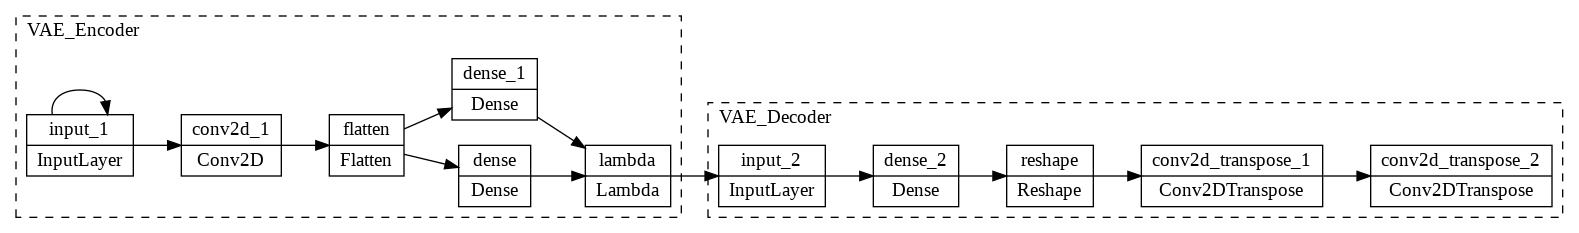

In [ ]:
plot_model(vae, expand_nested=True, rankdir='LR')

Generamos nuestra función de costos.

In [ ]:
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

In [ ]:
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

Y realizamos el entrenamiento de nuestro encoder.

In [ ]:
history = vae.fit(x=X_train_new,
                  y=X_train_new,
                  epochs=30,
                  batch_size=32,
                  validation_data=(X_test_new,X_test_new))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
59936/60000 [============================>.] - ETA: 0s - loss: 304.8711

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 54s 900us/sample - loss: 304.8500 - val_loss: 287.5861
Epoch 2/50
60000/60000 [==============================] - 54s 905us/sample - loss: 282.2744 - val_loss: 280.7457
Epoch 3/50
60000/60000 [==============================] - 63s 1ms/sample - loss: 277.6566 - val_loss: 277.1178
Epoch 4/50
60000/60000 [==============================] - 49s 821us/sample - loss: 275.3573 - val_loss: 275.7444
Epoch 5/50
60000/60000 [==============================] - 52s 874us/sample - loss: 274.0370 - val_loss: 274.8861
Epoch 6/50
60000/60000 [==============================] - 54s 904us/sample - loss: 273.0421 - val_loss: 273.9623
Epoch 7/50
60000/60000 [==============================] - 51s 855us/sample - loss: 272.3837 - val_loss: 273.6077
Epoch 8/50
60000/60000 [==============================] - 51s 857us/sample - loss: 271.7838 - val_loss: 273.4778
Epoch 9/50
60000/60000 [==============================] - 50s 832us/sample - loss: 271.4007 - val_loss: 272.3

Generamos un gráfico para ver la representación del espacio latente de las imágenes codificadas.

In [ ]:
encoded = encoder.predict(X_train_new)
encoded

array([[ 1.1099168 ,  0.66669226],
       [-0.7523889 ,  0.9893258 ],
       [-1.447106  , -0.86177367],
       ...,
       [-1.5090141 ,  0.5173176 ],
       [-1.0005587 , -1.5837958 ],
       [ 2.1614869 , -1.1453485 ]], dtype=float32)

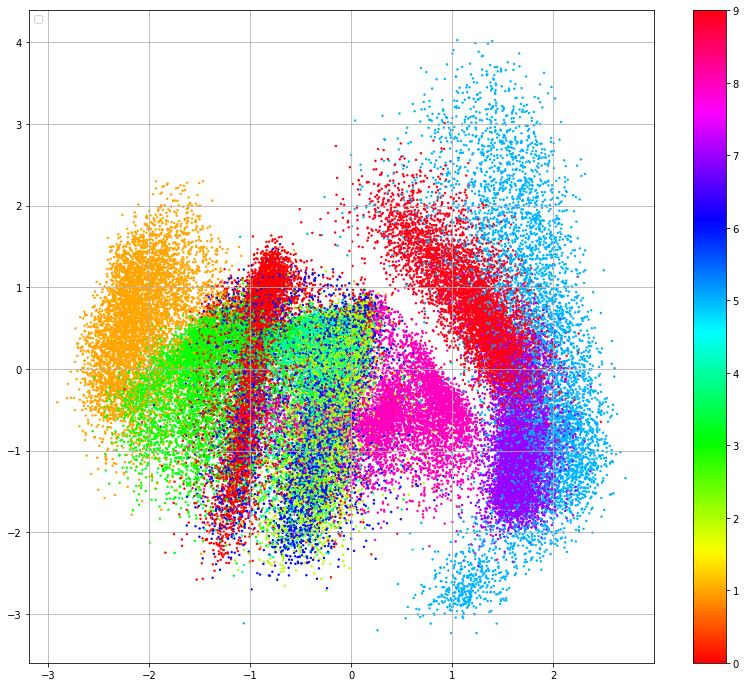

In [ ]:
plt.figure(figsize=(14,12))
plt.scatter(encoded[:,0], encoded[:,1], s=2, c=y_train, cmap='hsv')
plt.colorbar()
plt.legend(loc="upper left")
plt.grid()
plt.show()

Y con ello construiremos una función para generar unas imágenes.

In [ ]:
def display_image_sequence(x_start,y_start,x_end,y_end,no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    print(list(zip(x_axis,y_axis)))
    
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    
    new_points = np.hstack((x_axis, y_axis))
    new_images = decoder.predict(new_points)
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2])
    
    # Display some images
    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False,
                             sharey=True, figsize=(20, 7))
    counter = 0
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='gray')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()

[(-2.0, 1.0), (-1.75, 1.125), (-1.5, 1.25), (-1.25, 1.375), (-1.0, 1.5), (-0.75, 1.625), (-0.5, 1.75), (-0.25, 1.875), (0.0, 2.0)]


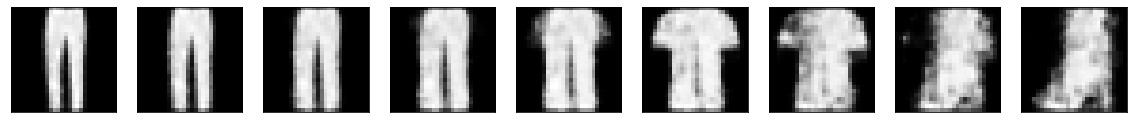

In [ ]:
display_image_sequence(-2,1,0,2,9)

[(1.0, 3.0), (1.0588235294117647, 2.6470588235294117), (1.1176470588235294, 2.2941176470588234), (1.1764705882352942, 1.9411764705882353), (1.2352941176470589, 1.588235294117647), (1.2941176470588236, 1.2352941176470587), (1.3529411764705883, 0.8823529411764706), (1.4117647058823528, 0.5294117647058822), (1.4705882352941178, 0.17647058823529393), (1.5294117647058822, -0.17647058823529438), (1.5882352941176472, -0.5294117647058827), (1.6470588235294117, -0.882352941176471), (1.7058823529411764, -1.2352941176470589), (1.7647058823529411, -1.5882352941176476), (1.8235294117647058, -1.9411764705882355), (1.8823529411764706, -2.2941176470588243), (1.9411764705882353, -2.647058823529412), (2.0, -3.0)]


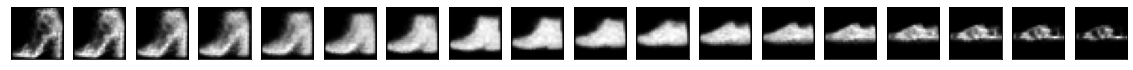

In [ ]:
display_image_sequence(1,3,2,-3,18)

O podemos nosotros mismos generar nuestras predicciones.

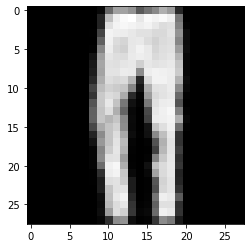

In [ ]:
x_axis = -2
y_axis = 2

new_points = [(x_axis, y_axis)]
new_images = decoder.predict([new_points])
new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2])

plt.imshow(new_images[0], cmap="gray")